# Entrenamiento de una red U-Net para segmentación de imágenes de lesiones en la piel

Entrenamos una red U-Net para la segmentación de imágenes de lesiones en la piel. El conjunto de datos que se emplea es el proporcionado por el ISIC 2016. El conjunto de datos se puede descargar desde la página web del desafío: https://challenge.isic-archive.com/data/.

## Importación de librerías

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from torchvision import models
from torchvision.transforms import Resize

from tqdm import tqdm


## Parámetros

In [2]:
IMAGE_SIZE = 64
BATCH_SIZE = 32
EPOCHS = 100
DEVICE = torch.device("mps")

## Carga de los imágenes de entrenamiento y de validación

In [4]:
metadata_dir = '/Users/alzorrcarri/ISIC2016Challenge'

metadata = pd.read_csv(os.path.join(metadata_dir, 'ISBI2016_ISIC_Part3B_Training_GroundTruth.csv'))
name_images = metadata['id_name'].tolist()

A la vez que cargamos las imágenes de entrenamiento y de validación, reescalamos las imágenes al tamaño indicado por el parámetro `IMAGE_SIZE` y las normalizamos al rango [0, 1].

In [5]:
data_dir = '/Users/alzorrcarri/ISIC2016Challenge/ISBI2016_ISIC_Part1_Training_Data'

resize = Resize((IMAGE_SIZE, IMAGE_SIZE))
images = []
for image_name in name_images:
    image_root = os.path.join(data_dir, image_name + '.jpg')
    image = plt.imread(image_root)
    image = torch.tensor(image)
    image = torch.transpose(image, 0, 2)
    image = resize(image)/255
    images.append(image)


Cargamos las máscaras de las imágenes de entrenamiento y de validación. Estas son imágenes en blanco y negro de la zona a segmentar donde se encuentra la lesión. Únicamente reescalamos dicha imagen al tamaño indicado anteriomente.

In [6]:
mask_data_dir = '/Users/alzorrcarri/ISIC2016Challenge/ISBI2016_ISIC_Part1_Training_GroundTruth'
masks = []
for mask_name in name_images:
    mask_root = os.path.join(mask_data_dir, mask_name + '_Segmentation.png')
    mask = plt.imread(mask_root)
    mask = torch.tensor(mask).unsqueeze(0)
    mask = resize(mask)
    masks.append(mask)

In [7]:
if len(images) != len(masks):
    raise ValueError('The number of images and masks is different')
else:
    print('Number of images and masks:', len(images)) 
    dataset = [{'image':image, 'mask':mask} for image, mask in zip(images, masks)]

Number of images and masks: 900


El conjunto de validación será una proporción del conjunto de imágenes de entrenamiento total.

In [8]:
train_loader = DataLoader(dataset[0:int(0.9*len(dataset))], batch_size = BATCH_SIZE, shuffle = True)
val_loader = DataLoader(dataset[int(0.9*len(dataset)):], batch_size = BATCH_SIZE, shuffle = True)

## Definición y entrenamiento de la U-Net

Definimos la clase para generar la red U-Net.

In [9]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, with_bn=False):
        super().__init__()
        if with_bn:
            self.step = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(),
            )
        else:
            self.step = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(),
            )
        
    def forward(self, x):
        return self.step(x)


class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, with_bn=False):
        super().__init__()
        init_channels = 32
        self.out_channels = out_channels

        self.en_1 = DoubleConv(in_channels    , init_channels  , with_bn)
        self.en_2 = DoubleConv(1*init_channels, 2*init_channels, with_bn)
        self.en_3 = DoubleConv(2*init_channels, 4*init_channels, with_bn)
        self.en_4 = DoubleConv(4*init_channels, 8*init_channels, with_bn)
        
        self.de_1 = DoubleConv((4 + 8)*init_channels, 4*init_channels, with_bn)
        self.de_2 = DoubleConv((2 + 4)*init_channels, 2*init_channels, with_bn)
        self.de_3 = DoubleConv((1 + 2)*init_channels, 1*init_channels, with_bn)
        self.de_4 = nn.Conv2d(init_channels, out_channels, 1)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
    
    def forward(self, x):
        e1 = self.en_1(x)
        e2 = self.en_2(self.maxpool(e1))
        e3 = self.en_3(self.maxpool(e2))
        e4 = self.en_4(self.maxpool(e3))
        
        d1 = self.de_1(torch.cat([self.upsample(e4), e3], dim=1))
        d2 = self.de_2(torch.cat([self.upsample(d1), e2], dim=1))
        d3 = self.de_3(torch.cat([self.upsample(d2), e1], dim=1))
        d4 = self.de_4(d3)

        if self.out_channels<2:
            return torch.sigmoid(d4)
        else:
            return torch.softmax(d4, 1)            


Definimos la red y como parámetros escogemos `in_channels=3` (ya que las imágenes son a color), `out_channels=1`(ya que la salida es una máscara binaria). Tomamos por optimizador a Adam, la función de pérdida será el MSE entre la salida y la máscara real de la imagen. Finalmente, durante el entrenamiento variamos el *learning rate* según la evolución del *loss* durante el entrenamiento.  

In [10]:
unet = UNet(3, 1, with_bn=True)
unet = unet.to(DEVICE)
optimizer = optim.Adam(unet.parameters(), lr=0.001)
loss = nn.MSELoss()
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, 
                                        patience=0, threshold=0.0001, threshold_mode='rel', 
                                        cooldown=0, min_lr=0, eps=1e-10, verbose=False)

/opt/anaconda3/envs/tfm/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


### Entrenamiento

In [11]:
loss_train_values = []
loss_val_values = []
lr_values = [] 

for epoch in range(EPOCHS):
    unet.train()
    epoch_loss = 0.0
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        image_batch = batch['image'].to(DEVICE)
        mask_batch = batch['mask'].to(DEVICE)
        optimizer.zero_grad(set_to_none=True)
        output = unet(image_batch)
        loss_value = loss(output, mask_batch)
        loss_value.backward()
        optimizer.step()
        epoch_loss += loss_value.item()
        progress_bar.set_postfix(loss=epoch_loss / (step + 1))

    loss_train_values.append(epoch_loss / len(train_loader))
    lr_values.append(lr_sch.get_last_lr()[0])

    lr_sch.step(epoch_loss / len(train_loader))

    if (epoch+1) % 5 == 0:
        unet.eval()
        val_loss = 0.0
        with torch.no_grad():
            for step, batch in enumerate(val_loader):
                image_batch = batch['image'].to(DEVICE)
                mask_batch = batch['mask'].to(DEVICE)
                output = unet(image_batch)

                loss_value = loss(output, mask_batch)
                val_loss += loss_value.item()

        loss_val_values.append(val_loss / len(val_loader))

        print(f"Validation loss: {val_loss / len(val_loader)}")

Epoch 4: 100%|██████████| 26/26 [00:01<00:00, 15.71it/s, loss=0.0732]


Validation loss: 0.11816356082757314


Epoch 9: 100%|██████████| 26/26 [00:01<00:00, 15.69it/s, loss=0.0495]


Validation loss: 0.07492303599913915


Epoch 14: 100%|██████████| 26/26 [00:01<00:00, 15.43it/s, loss=0.0303]


Validation loss: 0.0533335879445076


Epoch 19: 100%|██████████| 26/26 [00:01<00:00, 15.76it/s, loss=0.0255]


Validation loss: 0.052652994791666664


Epoch 24: 100%|██████████| 26/26 [00:01<00:00, 15.72it/s, loss=0.0201]


Validation loss: 0.05232790360848109


Epoch 29: 100%|██████████| 26/26 [00:01<00:00, 15.69it/s, loss=0.0176]


Validation loss: 0.05184938261906306


Epoch 34: 100%|██████████| 26/26 [00:01<00:00, 15.76it/s, loss=0.016] 


Validation loss: 0.05230792611837387


Epoch 39: 100%|██████████| 26/26 [00:01<00:00, 15.77it/s, loss=0.0147]


Validation loss: 0.053503566732009254


Epoch 44: 100%|██████████| 26/26 [00:01<00:00, 15.71it/s, loss=0.0145]


Validation loss: 0.05253329128026962


Epoch 49: 100%|██████████| 26/26 [00:01<00:00, 15.78it/s, loss=0.0148]


Validation loss: 0.05163190638025602


Epoch 54: 100%|██████████| 26/26 [00:01<00:00, 15.78it/s, loss=0.0146]


Validation loss: 0.05272327115138372


Epoch 59: 100%|██████████| 26/26 [00:01<00:00, 15.80it/s, loss=0.0149]


Validation loss: 0.053939349949359894


Epoch 64: 100%|██████████| 26/26 [00:01<00:00, 15.76it/s, loss=0.0144]


Validation loss: 0.053255289793014526


Epoch 69: 100%|██████████| 26/26 [00:01<00:00, 15.79it/s, loss=0.0146]


Validation loss: 0.051691929499308266


Epoch 74: 100%|██████████| 26/26 [00:01<00:00, 15.76it/s, loss=0.0152]


Validation loss: 0.05299771701296171


Epoch 79: 100%|██████████| 26/26 [00:01<00:00, 15.80it/s, loss=0.015] 


Validation loss: 0.05430752163132032


Epoch 84: 100%|██████████| 26/26 [00:01<00:00, 15.78it/s, loss=0.0159]


Validation loss: 0.051446703573067985


Epoch 89: 100%|██████████| 26/26 [00:01<00:00, 15.65it/s, loss=0.0153]


Validation loss: 0.051922169824441276


Epoch 94: 100%|██████████| 26/26 [00:01<00:00, 15.76it/s, loss=0.0149]


Validation loss: 0.05269386246800423


Epoch 99: 100%|██████████| 26/26 [00:01<00:00, 15.38it/s, loss=0.0146]


Validation loss: 0.054227616637945175


Tras el entrenamiento, guardamos el modelo y los valores del loss durante las distintas épocas del entrenamiento en un fichero csv.

In [12]:
# Guardamos el modelo
torch.save(unet.state_dict(), 'unet_ISIC2016_trained.pth')

# Escribir los valores de loss y accuracy para cada una de las épocas en un fichero
empty_string = ""
with open('unet_ISIC2016_training_data.csv', 'w') as f:
    f.write('epoch,loss_train,loss_val,lr\n')
    i = 0
    for epoch in range(EPOCHS):
        if (epoch+1) % 5 == 0:
            f.write(f"{epoch},{loss_train_values[epoch]},{loss_val_values[i]},{lr_values[epoch]}\n")
            i+=1
        else:
            f.write(f"{epoch},{loss_train_values[epoch]},{empty_string},{lr_values[epoch]}\n")

## Prueba del modelo sobre el conjunto de test

Cargamos el modelo ya entrenado para poner a prueba su eficacia sobre el conjunto de imágenes de test proporcionado por el ISIC 2016 Challenge.

In [5]:
# Cargamos el modelo
unet = UNet(3, 1, with_bn=True).to(DEVICE)
unet.load_state_dict(torch.load('unet_ISIC2016_trained.pth', map_location=DEVICE))

<All keys matched successfully>

Evidentemente, transformamos las imágenes de test para ajustarlas al tamaño y características con las que hemos entrenado a nuestra red.

In [13]:
# Cargamos el conjunto de test y hacemos las transformaciones necesarias
resize = Resize((IMAGE_SIZE, IMAGE_SIZE))
metadata_dir = '/Users/alzorrcarri/ISIC2016Challenge'
metadata = pd.read_csv(os.path.join(metadata_dir, 'ISBI2016_ISIC_Part3B_Test_GroundTruth.csv'))
name_images = metadata['id_name'].tolist()

data_dir = '/Users/alzorrcarri/ISIC2016Challenge/ISBI2016_ISIC_Part1_Test_Data'
test_images = []
for i in range(len(name_images)):
    image_root = os.path.join(data_dir, name_images[i] + '.jpg')
    image = plt.imread(image_root)
    image = torch.tensor(image)
    image = torch.transpose(image, 0, 2)
    image = resize(image)/255
    test_images.append(image)

mask_data_dir = '/Users/alzorrcarri/ISIC2016Challenge/ISBI2016_ISIC_Part1_Test_GroundTruth'
test_masks = []
for i in range(len(name_images)):
    mask_root = os.path.join(mask_data_dir, name_images[i] + '_Segmentation.png')
    mask = plt.imread(mask_root)
    mask = torch.tensor(mask).unsqueeze(0)
    mask = resize(mask)
    test_masks.append(mask)

In [14]:
if len(test_images) != len(test_masks):
    raise ValueError('The number of images and masks is different')
else:
    print('Number of images and masks:', len(test_images))
    test_dataset = [{'image':image, 'mask':mask} for image, mask in zip(test_images, test_masks)]

test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False)

Number of images and masks: 379


Calculamos la máscara predicha por el modelo para cada una de las imágenes de test y la guardamos en la lista `predictions`. Calculamos el valor medio del MSE entre las máscaras predichas y las reales para las imágenes de test.

In [15]:
loss = nn.MSELoss()
unet.eval()
test_loss = 0.0
predictions = []
with torch.no_grad():
    for step, batch in enumerate(test_loader):
        image_batch = batch['image'].to(DEVICE)
        mask_batch = batch['mask'].to(DEVICE)
        output = unet(image_batch)

        loss_value = loss(output, mask_batch)
        test_loss += loss_value.item()

        predictions.append(output)

In [16]:
test_loss/len(test_loader)

0.04529972250262896

In [17]:
predictions = torch.cat(predictions, 0)

Finalmente, ploteamos algunos casos de prueba para visualizar la eficacia de la red U-Net entrenada. De izquierda a derecha, se muestra la imagen original, la máscara real, la máscara predicha por la red y una superposición de la imagen real con la máscara predicha.

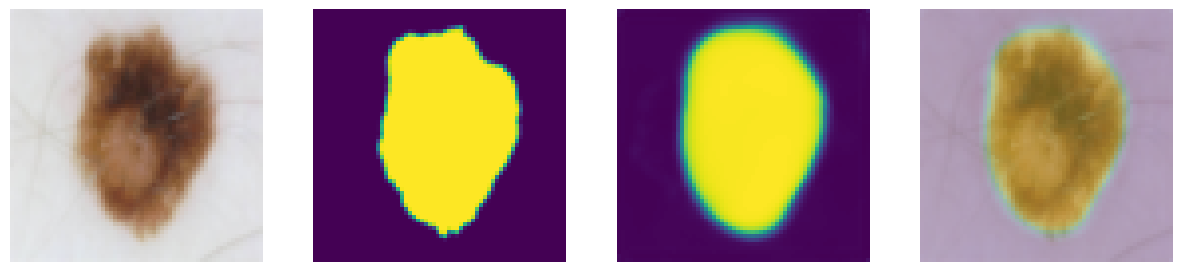

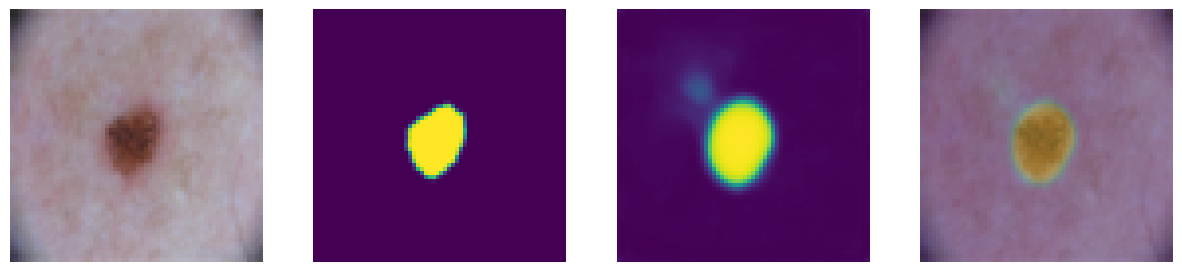

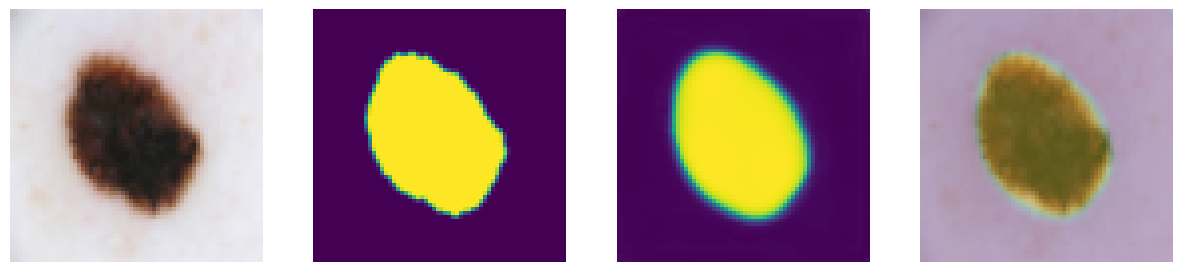

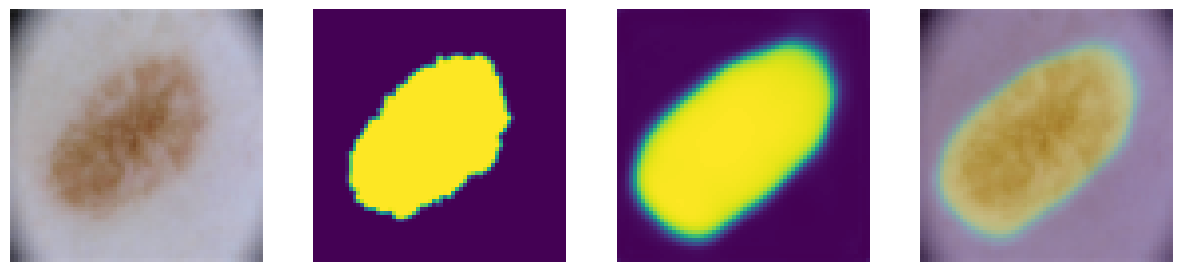

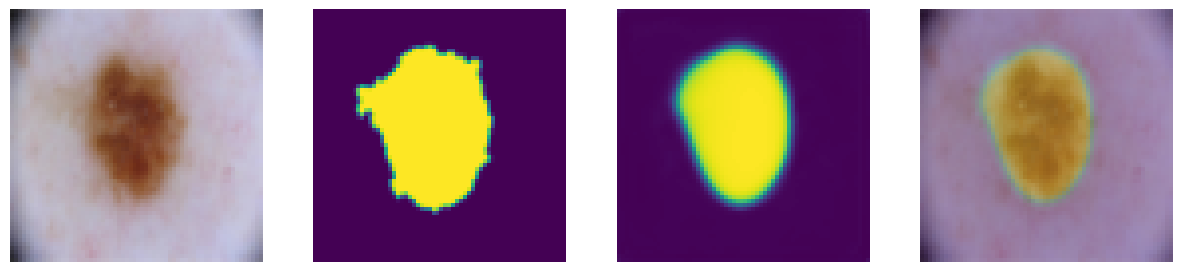

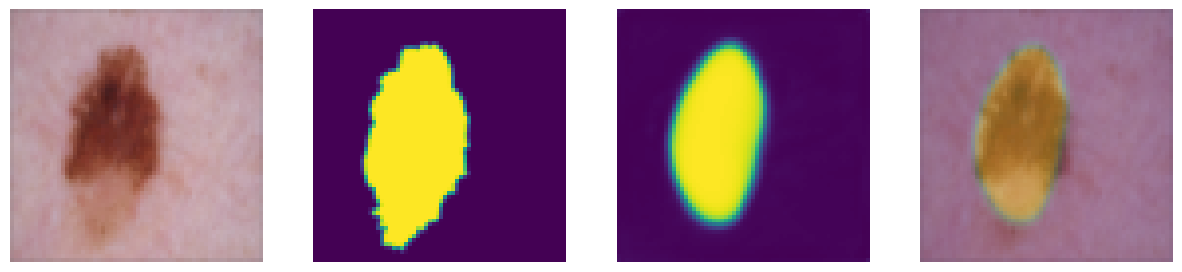

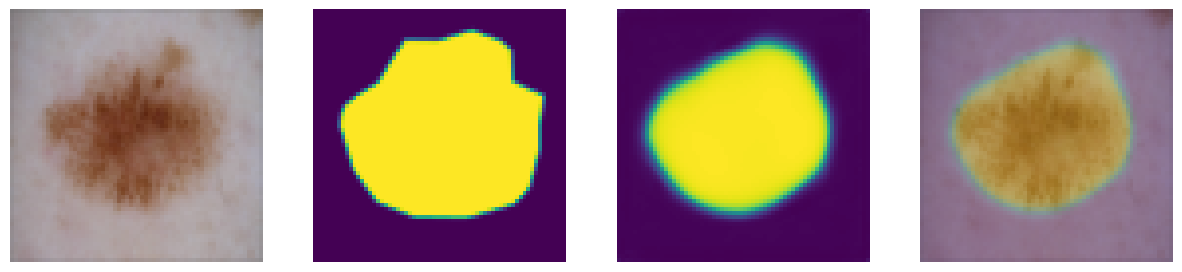

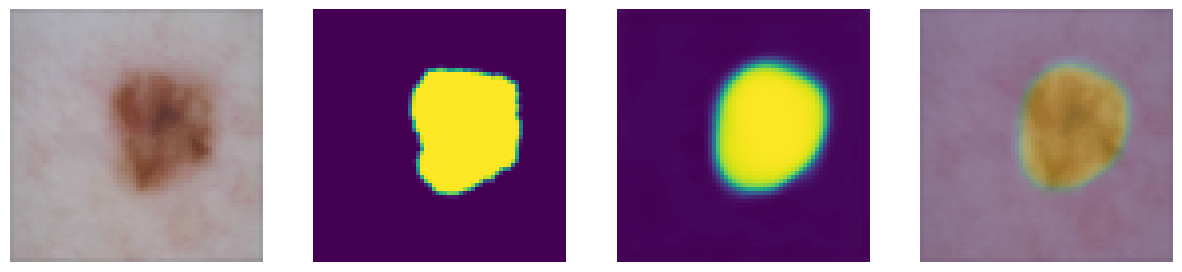

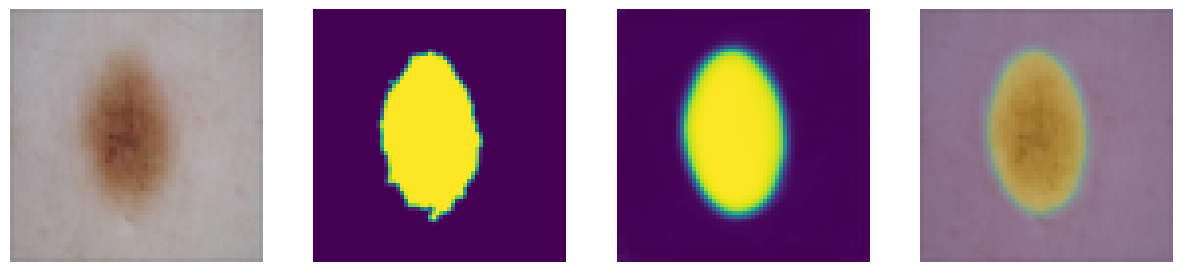

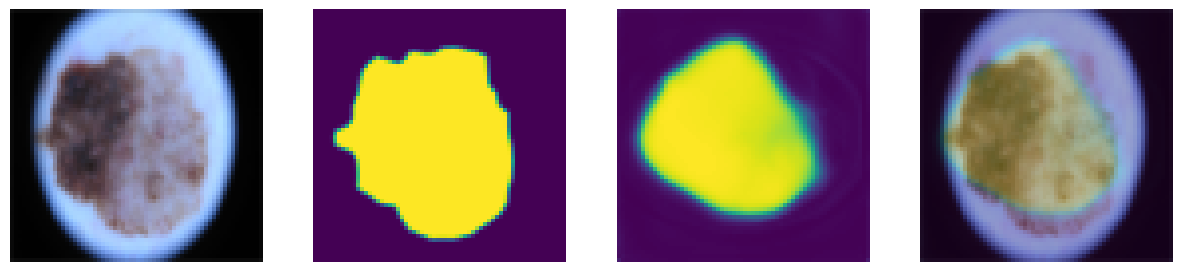

In [18]:
for i in range(10):
    fig, ax = plt.subplots(1,4, figsize=(15,5))
    # Quitar los ejes
    for a in ax:
        a.axis('off')

    ax[0].imshow(test_images[i].permute(2, 1, 0))
    ax[1].imshow(test_masks[i].squeeze())
    ax[2].imshow(predictions[i].squeeze().cpu())
    ax[3].imshow(test_images[i].cpu().permute(2, 1, 0))
    ax[3].imshow(predictions[i].squeeze().cpu(), alpha=0.3)
    
    plt.savefig('unet_ISIC2016_' + str(i) + '.png')
    plt.show()